# <span style="color:black; font-weight:bold;">Stereo CITE seq Mouse spleen Tutorial</span>
+ <span style="color:black; font-weight:bold;">Creator</span>: Bingjie Dai (17516970902@163.com)
+ <span style="color:black; font-weight:bold;">Date of Creation</span>: 10.10.2025
+ <span style="color:black; font-weight:bold;">Date of Last Modification</span>: 10.10.2025
+ <span style="color:black; font-weight:bold;">Download</span>: Stereo CITE-seq Mouse spleen data used in the tutorial is available at [Stereo_CITE-seq.h5ad](https://drive.google.com/open?id=1VkSMlaeBz020JGZHxVNqW-MKDUmlAaS_&usp=drive_fs)
Stereo CITE-seq is from [STOmics](https://www.stomics.tech/col1377)

In [1]:
from SpaLP.utils import prepare_inputs, set_seed,create_new_color_dict,Graph
from SpaLP.RandLA import SpatialAutoencoder
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
set_seed(7)

## <span style="color:black; font-weight:bold;">Loading Stereo CITE-seq Mouse spleen data</span>
The Xenium Breast Cancer data contains 295,215 cells and 128 proteins.

In [4]:
adata=sc.read_h5ad('/home/dbj/SpaLA/stereoseq/Stereo_CITE-seq.h5ad')
adata.var_names_make_unique()

In [5]:
adata

AnnData object with n_obs × n_vars = 295215 × 128
    obs: 'dnbCount', 'area', 'id', 'orig.ident', 'x', 'y'
    uns: 'bin_size', 'bin_type', 'key_record', 'merged', 'resolution', 'sn'
    obsm: 'cell_border', 'spatial'

## <span style="color:black; font-weight:bold;">Data preprocessing</span>
We use [scanpy](https://scanpy.readthedocs.io/en/stable/installation.html) package to perform standard data processing.  
The standard processed expression matrix was saved in adata.obsm[<span style="color:red;">'feat'</span>] and used as input to the model.

In [6]:
sc.pp.normalize_total(adata,inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata)
adata.obsm['feat']=adata.X

## <span style="color:black; font-weight:bold;">Compute Spatial Neighbor Graph and build the neighbor index matrix</span>
We compute the spatial Graph using 4 neighbors in Xenium Breast Cancer data. k=4

In [7]:
k=4
graph = prepare_inputs(adata, k, device)

## <span style="color:black; font-weight:bold;">Define Parameters</span>
The hidden layer dimension is 64, the Adam optimizer is used to optimize the model, the learning rate lr is 0.001, and the model is trained for 200 epochs.

In [8]:
in_channels = graph.features.shape[1]
model = SpatialAutoencoder(in_channels, out_channels=64).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
set_seed(7)
epochs = 200
pbar = tqdm(range(epochs), desc="Training",ncols=200)
for epoch in pbar:
    start_time = time.time()
    model.train()
    optimizer.zero_grad()
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    loss = criterion(reconstructed, graph.features)
    loss.backward()
    optimizer.step()
    elapsed = time.time() - start_time
    pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

Training: 100%|████████████████████████████| 200/200 [00:14<00:00, 14.11it/s, Epoch=199, Loss=0.8720]


## <span style="color:black; font-weight:bold;">Generate cell embedding and reconstructed gene expression</span>
Cell embedding was saved in adata.obsm[<span style="color:red;">'SpaLP'</span>]. Reconstructed protein expression is constructed as adata2

In [10]:
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

### Cell embedding

In [11]:
adata.obsm['SpaLP']=embedding

### Reconstructed protein expression

In [12]:
adata2=sc.AnnData(reconstructed)
adata2.obs=adata.obs
adata2.var=adata.var
adata2.uns=adata.uns
adata2.obsm=adata.obsm

## <span style="color:black; font-weight:bold;">Identify Niches</span>
We compute Leiden clustering based on the SpaLP embeddings to identify spatial niches.

In [17]:
sc.pp.neighbors(adata, use_rep='SpaLP')
sc.tl.leiden(adata,resolution=0.3,key_added='SpaLP')

## <span style="color:black; font-weight:bold;">Niche identified by SpaLP</span>

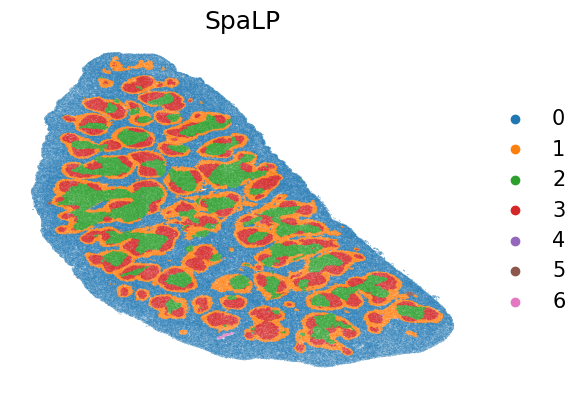

In [19]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (6,4.5)
plt.rcParams['font.size'] = 15
sc.pl.embedding(adata,color=['SpaLP'],basis='spatial',s=1,frameon=False)

## <span style="color:black; font-weight:bold;">Original protein expression spatial map</span>

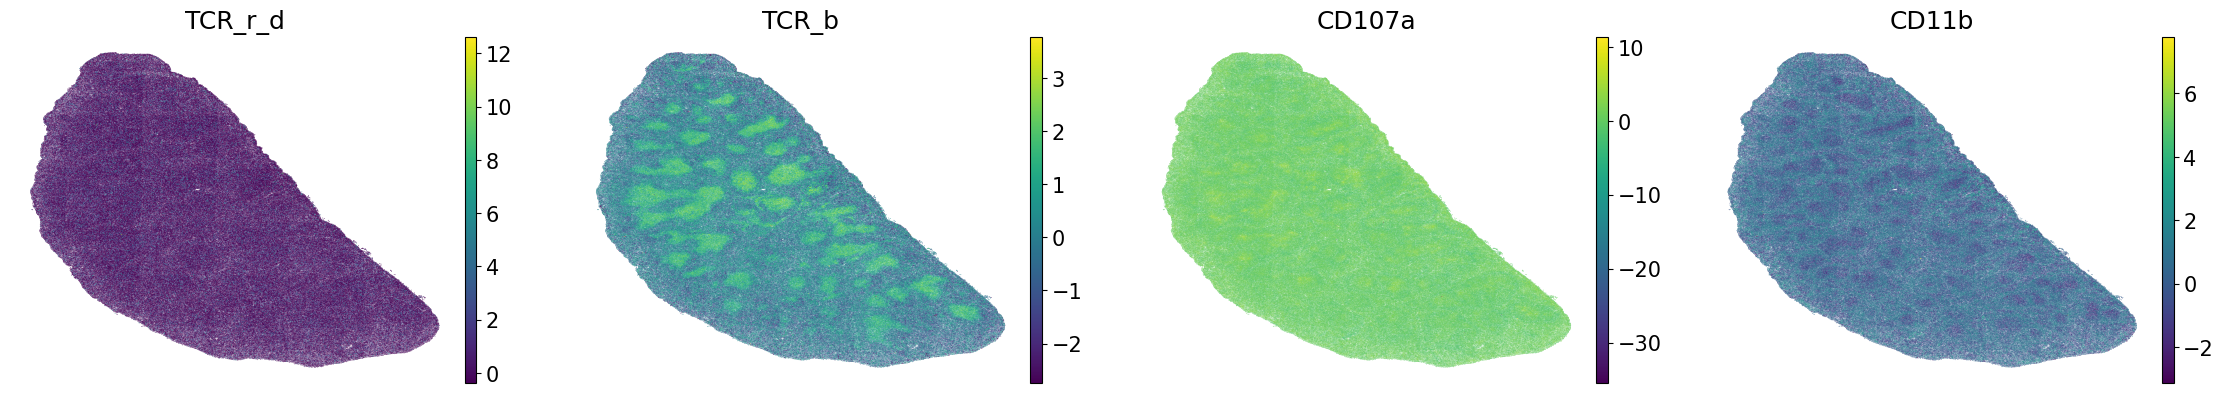

In [20]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (6,4.5)
plt.rcParams['font.size'] = 15
sc.pl.embedding(adata,color=['TCR_r_d','TCR_b','CD107a','CD11b'],basis='spatial',s=1,frameon=False,ncols=4)

## <span style="color:black; font-weight:bold;">Reconstructed protein expression spatial map</span>

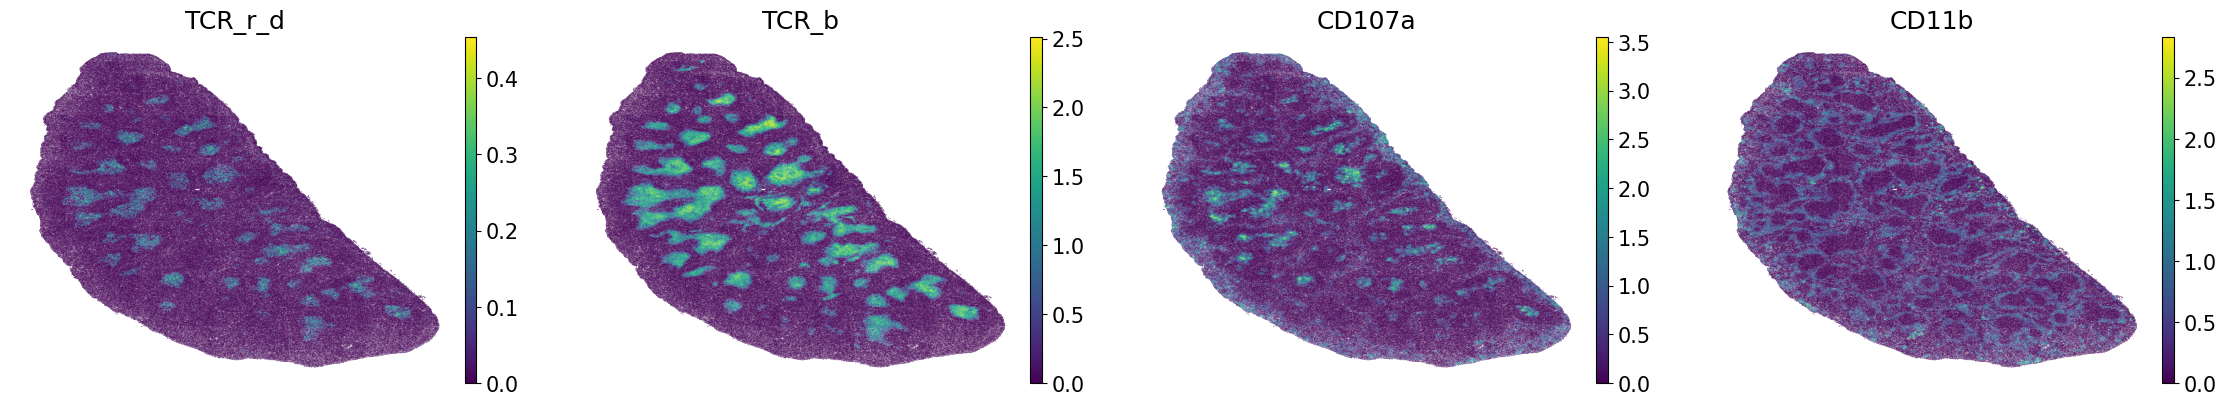

In [21]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (6,4.5)
plt.rcParams['font.size'] = 15
sc.pl.embedding(adata2,color=['TCR_r_d','TCR_b','CD107a','CD11b'],basis='spatial',s=1,frameon=False,ncols=4)